# Our Amazing Benchmark Evaluation

### Set path to log directory here.

In [111]:
LOG_DIR = "/Users/law/drive/msc/m3/adb/bm_results/bm_logs"

##  Run all cells and all the plots will magically appear :)

### Functions

In [112]:
import re

class BMRunInfo:
    def __init__(self, bm_type, bm_infos, final_info):
        self.bm_type = bm_type
        self.bm_infos = bm_infos
        self.final_info = final_info

# Example line (no linebreaks)
# 2018-08-12 18:56:45:761 10 sec: 4262 operations; 426.2 current ops/sec; est completion in 1 hour 18 minutes 
# [INSERT: Count=4266, Max=951807, Min=2522, Avg=12826.31, 90=16719, 99=58399, 99.9=947199, 99.99=951807]

BM_INFO_RE = re.compile(r'^\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}:\d{3} (\d{2,}) sec: (\d+) operations; (\d*.\d*) current ops/sec; .* \[[A-Z]+: Count=(\d*), Max=(\d*), Min=(\d*), Avg=(\d*.\d*|\d*), 90=(\d*), 99=(\d*), 99\.9=(\d*), 99\.99=(\d*)\]')

class BMInfo:
    def __init__(self, log_line):
        match = BM_INFO_RE.match(log_line)
        if match is None:
            raise ValueError("Bad log line: " + log_line)
        self.seconds = match.group(1)
        self.total_ops = match.group(2)
        self.ops_per_sec = match.group(3)
        self.ops_per_interval = match.group(4)
        self.max_latency = match.group(5)
        self.min_latency = match.group(6)
        self.avg_latecny = match.group(7)
        self.p90 = match.group(8)
        self.p99 = match.group(9)
        self.p999 = match.group(10)
        self.p9999 = match.group(11)

In [113]:
def get_bm_run_from_file(file_name):
    bm_infos = []
    final_info = {}
    bm_type = ""
    for line in open(file_name):
        if line.startswith("2018-") and "0 sec: 0 operations;" not in line:
            bm_infos.append(BMInfo(line))
            
        # [INSERT], AverageLatency(us), 1851.142024
        # [OVERALL], Throughput(ops/sec), 8293.62759124027
        # [READ], AverageLatency(us), 1948.265838
        elif line.startswith("[INSERT],") or line.startswith("[OVERALL],") or line.startswith("[READ],"):
            split_line = line.split(', ')
            final_info[split_line[1]] = int(float(split_line[2].strip()))

        if line.startswith('[INSERT]'):
            bm_type = "INSERT"
        elif line.startswith('[READ]'):
            bm_type = "READ"
            
    assert(bm_type != "")
    return BMRunInfo(bm_type, bm_infos, final_info)        

In [114]:
import os

def get_bm_runs(log_dir):
    runs = {}
    for file in os.listdir(log_dir):
        if not file.endswith(".txt"):
            continue
            
        runs[file] = get_bm_run_from_file(os.path.join(log_dir, file))
    return runs
    

In [115]:
RUNS = get_bm_runs(LOG_DIR)
LOADS = {file: run.final_info for file, run in runs.items() if file.startswith('load')}
READS = {file: run.final_info for file, run in runs.items() if file.startswith('read')}

In [116]:
def capacity_from_file(file):
    # read_capacity_1000-num_stores_1.txt
    match = re.search(r'capacity_(\d*)', file)
    if match is None:
        raise ValueError("bad file name: " + file)
    
    return int(match.group(1))

## Plots

In [117]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

In [122]:
import matplotlib.pyplot as plt

def get_info_per_capacity(runs, info_name):
    file_infos = [(file, info[info_name]) for file, info in runs.items()]
    cap_final_infos = [(capacity_from_file(f), info) for f, info in file_infos]
    cap_final_infos.sort(key=lambda x: x[0])
    caps, info = list(zip(*cap_final_infos))
    return caps, info

def plot_info_per_capacity(info_name, out_file_name):
    load_caps, load_info = get_info_per_capacity(LOADS, info_name)
    read_caps, read_info = get_info_per_capacity(READS, info_name)

    caps = list(range(len(load_caps)))
    
    plt.plot(caps, load_info, 'r--o', caps, read_info, 'b--^')
    plt.ylabel(info_name)
    plt.xlabel("Partition capacity")
    plt.ylim(ymin=0)
    
    max_y = int(max(max(load_info), max(read_info)) * 1.1)
    plt.axis([0, 7, 0, max_y])
    plt.xticks(range(len(caps)), [str(x) for x in load_caps], rotation="vertical")
    
    plt.legend(["INSERT", "READ"])

    plt.savefig(f"{out_file_name}.svg")
    plt.show()
    


/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


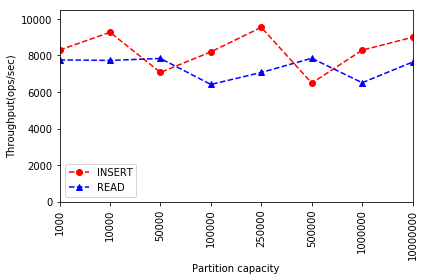

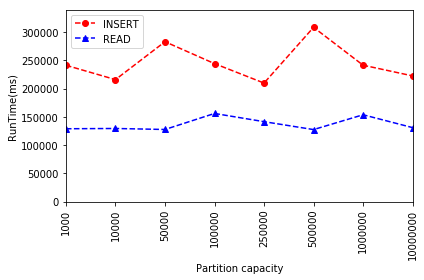

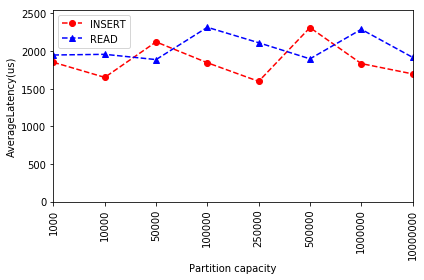

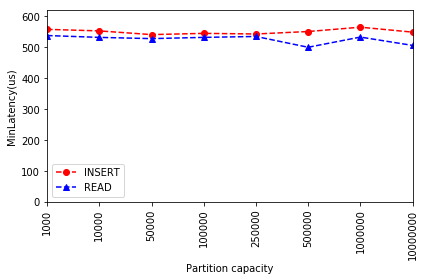

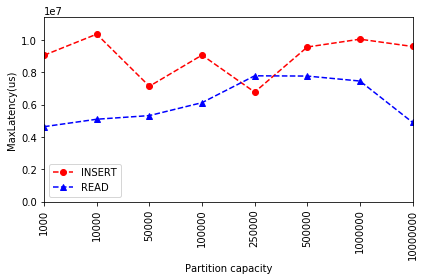

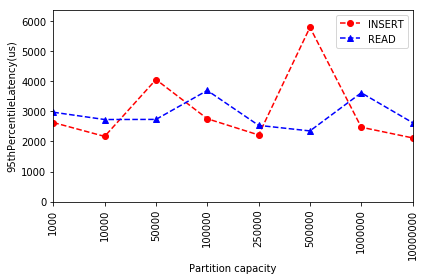

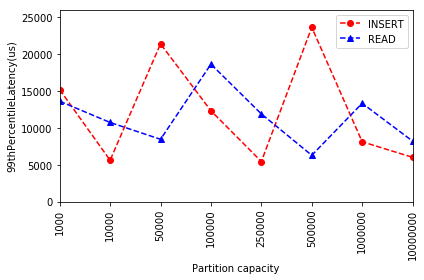

In [123]:
info_names = [
    ('Throughput(ops/sec)', 'throughput'),
    ('RunTime(ms)', 'runtime'),
    ('AverageLatency(us)', 'avg_latency'),
    ('MinLatency(us)', 'min_latency'),
    ('MaxLatency(us)', 'max_latency'),
    ('95thPercentileLatency(us)', '95p_latency'),
    ('99thPercentileLatency(us)', '99p_latecny')
]

for info_name, out_file_name in info_names:
    plot_info_per_capacity(info_name, out_file_name)
